In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import trange, tqdm
from matplotlib.dates import date2num
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import copy
import numpy as np
from datetime import datetime
import os
import zipfile
import random

from transformers import BertForSequenceClassification, AutoTokenizer, pipeline, BertTokenizer

2024-12-13 09:38:10.109603: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-13 09:38:10.719322: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Pre-trained LLM
model = BertForSequenceClassification.from_pretrained(
    "StephanAkkerman/FinTwitBERT-sentiment",
    num_labels=3,
    id2label={0: "neutral", 1: "positive", 2: "negative"},
    label2id={"neutral": 0, "positive": 1, "negative": 2},
)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(
    "StephanAkkerman/FinTwitBERT-sentiment"
)

# Construct a Huggingface pipeline!
sentiment_classifier = pipeline(
    "text-classification", model=model, tokenizer=tokenizer, device=1, 
    top_k=None, padding=True, truncation=True, max_length=256
)

Device set to use cuda:1


## Create dataset and dataloader

In [3]:
import os
import zipfile
from torch.utils.data import Dataset

class getDataset(Dataset):
    def __init__(self, root_data_dir, stock_code):
        self.root_data_dir = root_data_dir
        self.stock_code = stock_code
        self.data_dir = os.path.join(self.root_data_dir, self.stock_code)
        
        # Get the list of files
        self.file_list = [f for f in os.listdir(self.data_dir) if os.path.isfile(os.path.join(self.data_dir, f))]
        self.num_samples = len(self.file_list)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.file_list[idx])
        with open(file_path, 'r', encoding='utf-8') as file:
            raw_data = file.read()
            
        text_data = raw_data.split(" : ")[-1]
        time_data = raw_data.split(" : ")[0]
            
        return text_data, time_data


In [4]:
# We will give the dir name and location here to load it
stock_code = "nab"
root_data_dir = "./"
dataset = getDataset(root_data_dir, stock_code)
loader = DataLoader(dataset, batch_size=32)

In [6]:
text_data, time_data = dataset.__getitem__(7)

In [7]:
time_data

'2020-06-19T13:02:00+10:00'

In [8]:
text_data

'time will tell.But your prediction every other week "of it will be back down" just hasn\'t happened.Has it dropped under $17 since the SPP, it might have, I haven\'t noticed.'

In [10]:
rand_indx = random.randint(0, len(dataset))
text_data, time_data = dataset.__getitem__(rand_indx)
with torch.cuda.amp.autocast():
        outputs = sentiment_classifier([text_data])

/tmp/ipykernel_1456859/2052151285.py:3: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


In [11]:
outputs

[[{'label': 'negative', 'score': 0.48239922523498535},
  {'label': 'positive', 'score': 0.41911572217941284},
  {'label': 'neutral', 'score': 0.0984850525856018}]]

In [12]:
positive_score = []
negative_score = []
sentiment_datetime = []

for (input_data, time_data) in tqdm(loader):
    with torch.cuda.amp.autocast():
        outputs = sentiment_classifier(list(input_data), batch_size=len(input_data))

    for (output, td) in zip(outputs, time_data):
        for label in output:
            if label["label"] == 'positive':
                positive_score.append(label["score"])
            elif label["label"] == 'negative':
                negative_score.append(label["score"])

        sentiment_datetime.append(td)

  0%|          | 0/531 [00:00<?, ?it/s]

/tmp/ipykernel_1456859/4290255830.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [13]:
# Create a panda dataframe
df = pd.DataFrame({
    'Datetime': sentiment_datetime,
    'positive': positive_score,
    'negative': negative_score,

})
# Set index to the date time
df['Datetime'] = pd.to_datetime(df['Datetime'], utc=True)

# Sort all rows by the datetimeindex
df.set_index('Datetime', inplace=True)
df.sort_index(inplace=True)

In [14]:
# Calculate a 'score' using the positive and negative predictions
df['score'] = (df['positive'] - df['negative'])/(df['positive'] + df['negative'])

# Calculate median sentiment for everyday
df_daily = df.resample('D').median()
df_daily.fillna(0, inplace=True)

# Count the number of entries per day
df_daily_count = df.resample('D').size()

# If you want to add this count to your existing df_daily DataFrame:
df_daily['entry_count'] = df_daily_count
df_daily['entry_count_ma'] = df_daily['entry_count'].rolling(window=28, center=False).mean()

# Calculate a 28 day moving average of the score
df_daily['score_ma'] = df_daily['score'].rolling(window=28, center=False).mean()

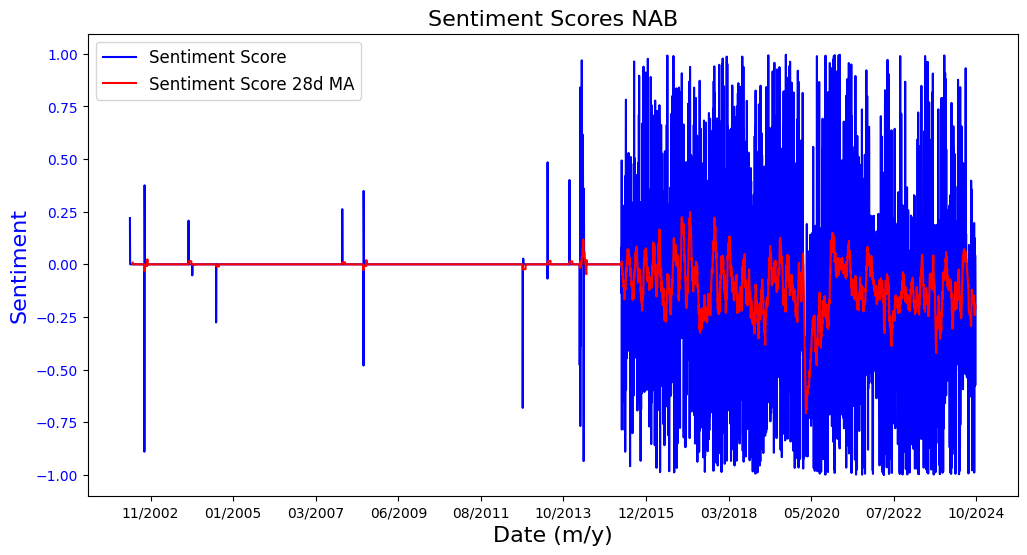

In [15]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the sentiment score on the first y-axis
ax1.plot(df_daily.index, 
         df_daily['score'], color='blue', label='Sentiment Score')

ax1.plot(df_daily.index, 
         df_daily['score_ma'], color='red', label='Sentiment Score 28d MA')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Sentiment', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

ax1.legend(loc='upper left', fontsize=12)

_ = plt.title('Sentiment Scores ' + stock_code.upper(), fontsize=16)

In [16]:
# Download the stock price data to compare
msft = yf.Ticker(stock_code + ".ax")
stock_data = msft.history(period = "10y", interval = "1d")
stock_data.drop('Dividends', axis=1, inplace=True)
stock_data.drop('Stock Splits', axis=1, inplace=True)

# Get a price for every day (including weekends etc)
stock_data = stock_data.resample('D').mean()

# Fill forward price data (carry the price data forward for weekends etc)
stock_data.fillna(method='ffill', inplace=True)

# Get a 28 day and 120 day moving average of the close price
stock_data['close_ma'] = stock_data['Close'].rolling(window=28, center=False).mean()
stock_data['close_120_ma'] = stock_data['Close'].rolling(window=120, center=False).mean()
stock_data.dropna(inplace=True)

# Calculate the short term price movements by subtracting the 120 day MA
stock_data['close_diff'] = stock_data['Close'] - stock_data['close_120_ma']

/tmp/ipykernel_1456859/4154189120.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill', inplace=True)


In [17]:
# Cut the sentiment data to match the same time period as the stock price data
specific_date = stock_data.index[0]

# Filter the DataFrame to get data after the specific date
df_after_specific_date = df_daily.loc[specific_date:]

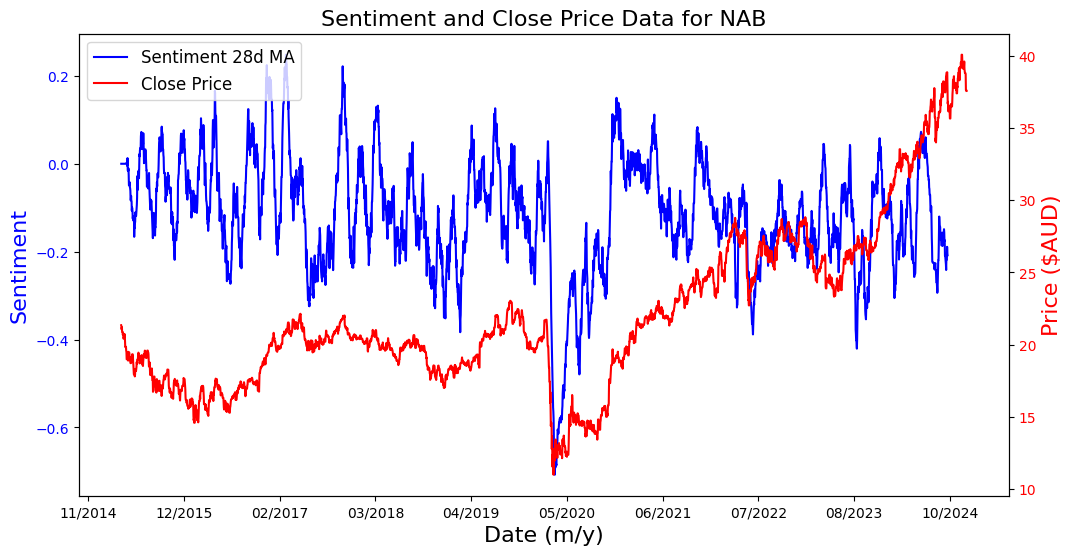

In [18]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the sentiment score on the first y-axis
ax1.plot(df_after_specific_date.index, 
         df_after_specific_date['score_ma'], color='blue', label='Sentiment 28d MA')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Sentiment', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

# Create the second y-axis
ax2 = ax1.twinx()

# Plot negative sentiment on the second y-axis
ax2.plot(stock_data.index, stock_data['Close'], 
         color='red', label='Close Price')

ax2.set_ylabel('Price ($AUD)', color='red', fontsize=16)
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)

_ = plt.title('Sentiment and Close Price Data for ' + stock_code.upper(), fontsize=16)

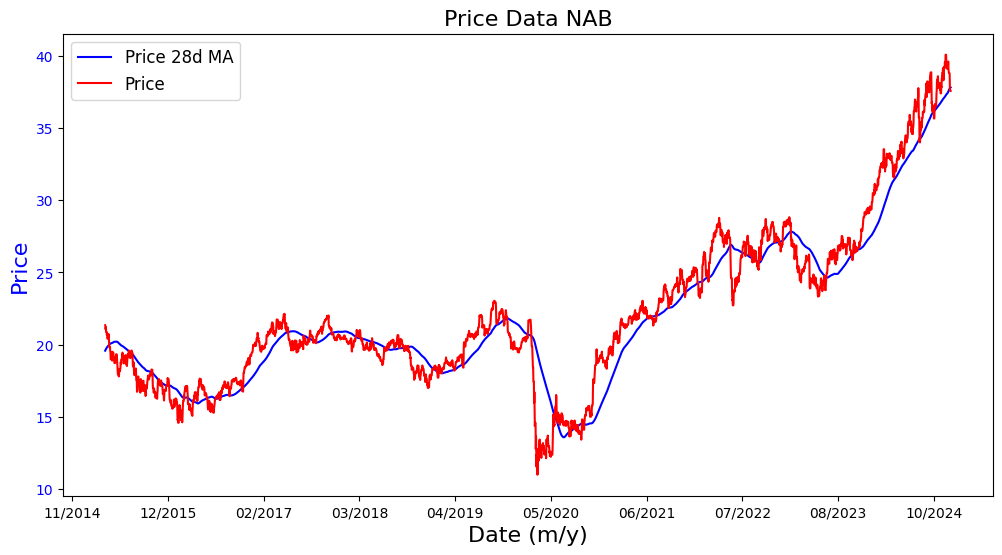

In [19]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the sentiment score on the first y-axis
ax1.plot(stock_data.index, 
         stock_data['close_120_ma'], color='blue', label='Price 28d MA')

ax1.plot(stock_data.index, 
         stock_data['Close'], color='red', label='Price')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Price', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

ax1.legend(loc='upper left', fontsize=12)

_ = plt.title('Price Data ' + stock_code.upper(), fontsize=16)

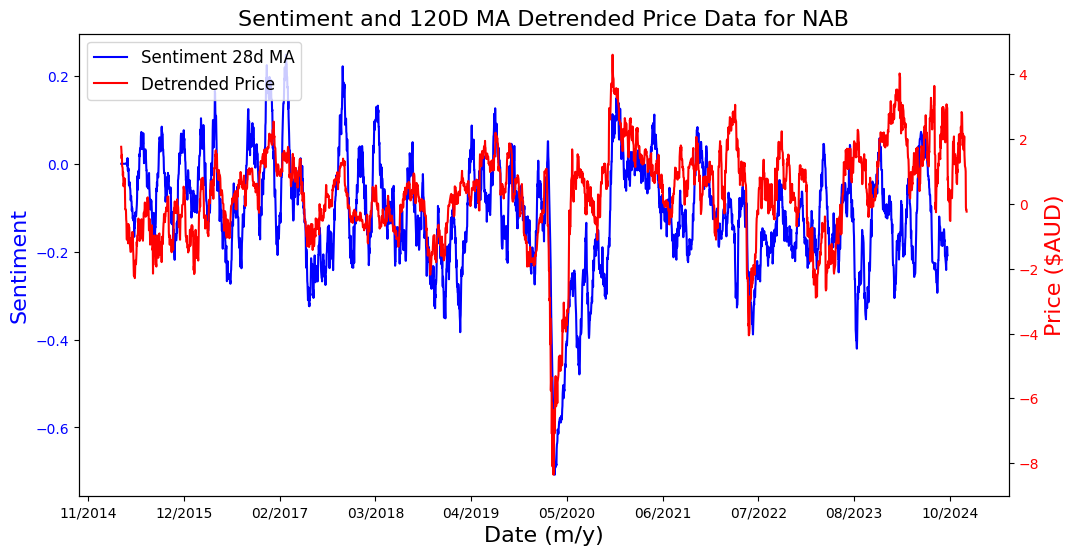

In [20]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot positive and neutral sentiment on the first y-axis
ax1.plot(df_after_specific_date.index, 
         df_after_specific_date['score_ma'], color='blue', label='Sentiment 28d MA')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Sentiment', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

# Create the second y-axis
ax2 = ax1.twinx()

# Plot negative sentiment on the second y-axis
ax2.plot(stock_data.index, stock_data['close_diff'], 
         color='red', label='Detrended Price')

ax2.set_ylabel('Price ($AUD)', color='red', fontsize=16)
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)

_ = plt.title('Sentiment and 120D MA Detrended Price Data for ' + stock_code.upper(), fontsize=16)

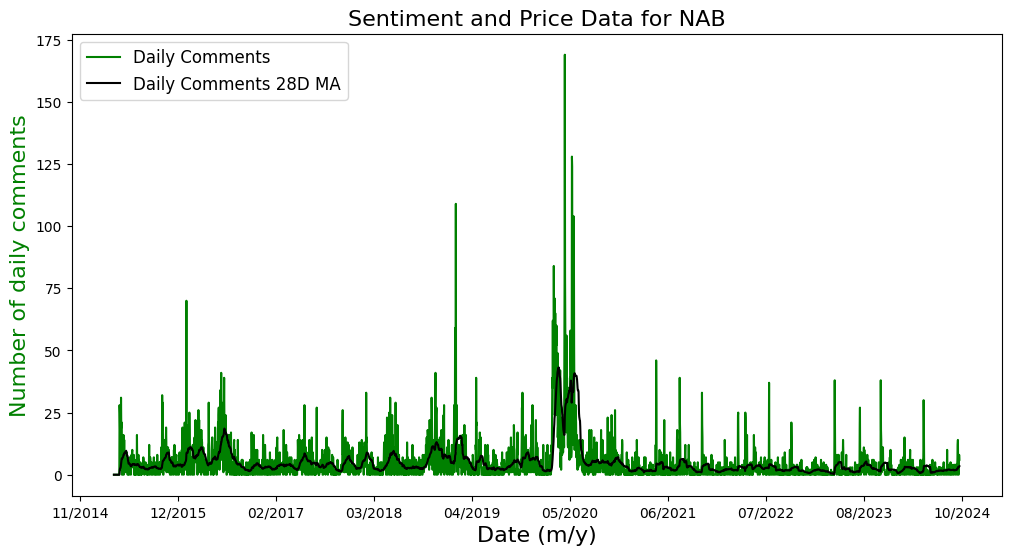

In [21]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot positive and neutral sentiment on the first y-axis
ax1.plot(df_after_specific_date.index, 
         df_after_specific_date['entry_count'], color='green', label='Daily Comments')

ax1.plot(df_after_specific_date.index, 
         df_after_specific_date['entry_count_ma'], color='k', label='Daily Comments 28D MA')

ax1.set_ylabel('Number of daily comments', color='green', fontsize=16)
ax1.tick_params(axis='y', labelcolor='green')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.tick_params(axis='y', labelcolor='black')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

# Add legend
ax1.legend(loc='upper left', fontsize=12)

_ = plt.title('Sentiment and Price Data for ' + stock_code.upper(), fontsize=16)